In [ ]:

#GEM MIXTURE GENERATOR
%tensorflow_version 1.x

!nvcc --version
!nvidia-smi

import numpy as np 
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
 



TensorFlow 1.x selected.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Using TensorFlow backend.


In [ ]:
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive"
def getData(pathd,shape):
    #file i/o çalışılmalı
    Alldatas=[]
    img_data=[]
    img_data=os.listdir(pathd)
    for image in img_data:
        _,extension = os.path.splitext(image)
        if(extension==".jpg" or extension==".jpeg" or extension==".png"):
            img=load_img(pathd+"/"+image)
            img=img.resize((shape[0],shape[1]))
            x=img_to_array(img)
            # x=x.reshape((1,) + x.shape)
            Alldatas.append(x)
    return Alldatas

def preProcess(data):
  # EDIT DATASET AND RESHAPE
  datat=np.asarray(data,dtype="float")
  datat=(datat-127.5)/127.5 
  testCount=datat.shape[0]
   
  return datat

 
SCALE=32 #RESIZE ALL IMAGES TO 30X30

checkpoint = ModelCheckpoint( "gemmodelGAN.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
LRchange = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=30,
    verbose=1,
    mode='min',
     cooldown=0,
    min_lr=0.0001)
callbacklists=[checkpoint,LRchange]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [ ]:
train = getData("DataSets/GEM/ALL",(SCALE,SCALE ))
train = preProcess(train)

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint 
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.models import load_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.001 )
	model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.001 )
	model.compile(loss='mse', optimizer=opt)
	return model
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model2.h5' 
	g_model.save(filename)
	filename = 'discriminator_model2.h5' 
	d_model.save(filename)


# train the generator and discriminator
def trainn(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=128, onlyGenerator=False):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			if (not onlyGenerator):
				X_real, y_real = generate_real_samples(dataset, half_batch)
				# update discriminator model weights
				d_loss1, _ = d_model.train_on_batch(X_real, y_real)
				# generate 'fake' examples
				X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
				# update discriminator model weights
				d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
				# prepare points in latent space as input for the generator
				X_gan = generate_latent_points(latent_dim, n_batch)
				# create inverted labels for the fake samples
				y_gan = ones((n_batch, 1))
				# update the generator via the discriminator's error
				g_loss = gan_model.train_on_batch(X_gan, y_gan)
				# summarize loss on this batch
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
			else:
				X_gan = generate_latent_points(latent_dim, n_batch)
				# create inverted labels for the fake samples
				y_gan = ones((n_batch, 1))
				# update the generator via the discriminator's error
				g_loss = gan_model.train_on_batch(X_gan, y_gan)
				# summarize loss on this batch
				print('>%d, %d/%d, g=%.3f' %
					(i+1, j+1, bat_per_epo,  g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:

# size of the latent space
latent_dim = 100
# create the discriminator
#d_model = define_discriminator()
# create the generator
#g_model = define_generator(latent_dim)
g_model = load_model("generator_modelY.h5")
d_model = load_model("discriminator_modelY.h5") 
print(g_model.summary())
print(d_model.summary())
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = train
# train model
trainn(g_model, d_model, gan_model, dataset, latent_dim,onlyGenerator=False)

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


KeyboardInterrupt: ignored

In [ ]:
trainn(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=400)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/21, d1=0.606, d2=0.611 g=0.892
>1, 2/21, d1=0.563, d2=0.665 g=0.878
>1, 3/21, d1=0.569, d2=0.648 g=0.850
>1, 4/21, d1=0.591, d2=0.660 g=0.919
>1, 5/21, d1=0.620, d2=0.697 g=0.947
>1, 6/21, d1=0.623, d2=0.599 g=1.067
>1, 7/21, d1=0.557, d2=0.488 g=1.133
>1, 8/21, d1=0.618, d2=0.554 g=1.078
>1, 9/21, d1=0.669, d2=0.554 g=0.983
>1, 10/21, d1=0.651, d2=0.723 g=0.919
>1, 11/21, d1=0.614, d2=0.753 g=0.902
>1, 12/21, d1=0.599, d2=0.744 g=0.916
>1, 13/21, d1=0.624, d2=0.641 g=0.919
>1, 14/21, d1=0.715, d2=0.694 g=0.957
>1, 15/21, d1=0.650, d2=0.654 g=0.934
>1, 16/21, d1=0.654, d2=0.665 g=0.994
>1, 17/21, d1=0.632, d2=0.605 g=1.004
>1, 18/21, d1=0.667, d2=0.565 g=1.033
>1, 19/21, d1=0.715, d2=0.598 g=0.962
>1, 20/21, d1=0.665, d2=0.626 g=0.963
>1, 21/21, d1=0.613, d2=0.602 g=0.965
>2, 1/21, d1=0.682, d2=0.652 g=1.020
>2, 2/21, d1=0.730, d2=0.608 g=0.998
>2, 3/21, d1=0.654, d2=0.610 g=0.987
>2, 4/21, d1=0.661, d2=0.613 g=0.927
>2, 5/21, d1=0.660, d2=0.639 g=0.932
>2, 6/21, d1=0.680, d2=0.5

# GENERATOR

In [ ]:
g_model = load_model("generator_modelY.h5")
d_model = load_model("discriminator_modelY.h5")
# create the gan
gan_model = define_gan(g_model, d_model)

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Generate True classified Gems

In [62]:
x,_ = generate_fake_samples(g_model, 100, 100)
success = []
for image in x:
  image = np.reshape(image,(1,)+image.shape)
  val = d_model.predict(image)
  if( val>0.01 ):
    print(val)
    success.append(image)

len(success)

[[0.01366176]]
[[0.03365627]]
[[0.01292918]]
[[0.01433329]]
[[0.08331888]]
[[0.07844178]]
[[0.03593605]]
[[0.10511497]]
[[0.01029102]]
[[0.02559311]]
[[0.01337796]]
[[0.06413171]]
[[0.02293136]]
[[0.40963247]]
[[0.03975451]]
[[0.01452075]]
[[0.02403022]]
[[0.02764402]]
[[0.02686366]]
[[0.05274791]]
[[0.02551854]]
[[0.36146396]]
[[0.09898796]]
[[0.08032222]]
[[0.01554654]]


25

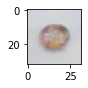

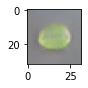

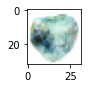

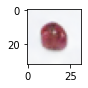

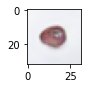

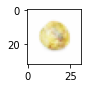

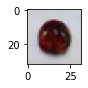

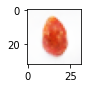

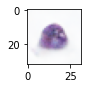

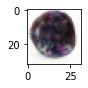

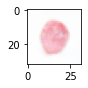

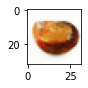

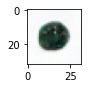

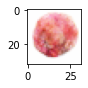

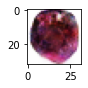

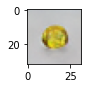

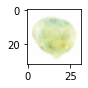

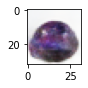

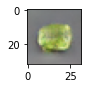

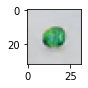

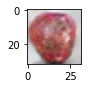

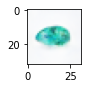

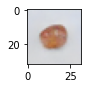

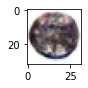

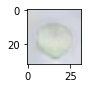

In [63]:

for image in success:
  plt.figure(figsize=(1,1))
  image = (image + 1)/2.0 
  plt.imshow(image.reshape(32,32,3))
  plt.show()
  